In [1]:

!pip install flaml[notebook,forecast]

     |████████████████████████████████| 227 kB 29.4 MB/s 
     |████████████████████████████████| 22.3 MB 1.2 MB/s 
     |████████████████████████████████| 67.4 MB 25 kB/s 
     |████████████████████████████████| 2.0 MB 48.6 MB/s 
     |████████████████████████████████| 9.5 MB 34.7 MB/s 
     |████████████████████████████████| 65 kB 4.0 MB/s 
     |████████████████████████████████| 2.6 MB 37.8 MB/s 
     |████████████████████████████████| 757 kB 46.9 MB/s 
     |████████████████████████████████| 158 kB 52.5 MB/s 
     |████████████████████████████████| 12.4 MB 162 kB/s 
     |████████████████████████████████| 49 kB 5.4 MB/s 
     |████████████████████████████████| 178 kB 58.8 MB/s 
  Created wheel for openml: filename=openml-0.10.2-py3-none-any.whl size=190318 sha256=baf061ca2b45fcc47eb716bb7e27cef06aef0c1cbb1dc0550198a2a96297e327
  Stored in directory: /root/.cache/pip/wheels/9c/9e/f3/6a5ebf16527d7fe22d9bc1652bc9beb5dc9fcfdeb75e805400
  Created wheel for liac-arff: filename=liac_arff-

In [2]:
import statsmodels.api as sm
data = sm.datasets.co2.load_pandas()
data = data.data
data = data['co2'].resample('MS').mean()
data = data.fillna(data.bfill())  
data = data.to_frame().reset_index()
print(data)

         index         co2
0   1958-03-01  316.100000
1   1958-04-01  317.200000
2   1958-05-01  317.433333
3   1958-06-01  315.625000
4   1958-07-01  315.625000
..         ...         ...
521 2001-08-01  369.425000
522 2001-09-01  367.880000
523 2001-10-01  368.050000
524 2001-11-01  369.375000
525 2001-12-01  371.020000

[526 rows x 2 columns]


In [3]:
num_samples = data.shape[0]
time_horizon = 12
split_idx = num_samples - time_horizon
X_train = data[:split_idx]  
X_test = data[split_idx:]['index'] 
y_test = data[split_idx:]['co2']


Run FLAML

In [4]:

from flaml import AutoML
automl = AutoML()

In [5]:
settings = {
    "time_budget": 180,  # total running time in seconds
    "metric": 'mape',  # primary metric for validation: 'mape' is generally used for forecast tasks
    "task": 'forecast',  # task type
    "log_file_name": 'CO2_forecast.log',  # flaml log file
    "eval_method": "holdout",  # validation method can be chosen from ['auto', 'holdout', 'cv']
    "split_type": 'time'  # for foretask task, 'split_type' has to be 'time'
}

In [6]:
automl.fit(dataframe=X_train,  
           label=('index', 'co2'),  
           **settings, 
           period=time_horizon)

[flaml.automl: 09-11 03:58:19] {1289} INFO - Evaluation method: holdout
[flaml.automl: 09-11 03:58:19] {1318} INFO - Minimizing error metric: mape
[flaml.automl: 09-11 03:58:19] {1345} INFO - List of ML learners in AutoML Run: ['fbprophet', 'arima', 'sarimax']
[flaml.automl: 09-11 03:58:19] {1538} INFO - iteration 0, current learner fbprophet
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[flaml.automl: 09-11 03:58:23] {1702} INFO -  at 4.0s,	best fbprophet's error=0.0007,	best fbprophet's error=0.0007
INFO:flaml.automl: at 4.0s,	best fbprophet's error=0.0007,	best fbprophet's error=0.0007
[flaml.automl: 09-11 03:58:23] {1538} INFO - iteration 1, current learner fbprophet
INFO:flaml.automl:iteration 1, current learner fbprophet
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:

In [7]:
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print(f'Best mape on validation data: {automl.best_loss}')
print(f'Training duration of best run: {automl.best_config_train_time}s')

Best ML leaner: fbprophet
Best hyperparmeter config: {'changepoint_prior_scale': 0.026349035969911335, 'seasonality_prior_scale': 1.5914763468191142, 'holidays_prior_scale': 6.860537461967591, 'seasonality_mode': 'additive'}
Best mape on validation data: 0.00047703801017392566
Training duration of best run: 2.602839946746826s


In [8]:
flaml_y_pred = automl.predict(X_test)
print('Predicted labels', flaml_y_pred)
print('True labels', y_test)

Predicted labels 0     370.433226
1     371.159010
2     372.213648
3     373.404204
4     373.898479
5     373.389386
6     372.035299
7     370.129374
8     368.545801
9     368.624857
10    369.841590
11    371.114037
Name: yhat, dtype: float64
True labels 514    370.175
515    371.325
516    372.060
517    372.775
518    373.800
519    373.060
520    371.300
521    369.425
522    367.880
523    368.050
524    369.375
525    371.020
Name: co2, dtype: float64


In [9]:
from flaml.ml import sklearn_metric_loss_score
print('mape', '=', sklearn_metric_loss_score('mape', flaml_y_pred, y_test))

mape = 0.001097269065441286


In [10]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, train_loss_history = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=180)

for config in config_history:
    print(config)

{'Current Learner': 'fbprophet', 'Current Sample': 502, 'Current Hyper-parameters': {'changepoint_prior_scale': 0.010000000000000002, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}, 'Best Learner': 'fbprophet', 'Best Hyper-parameters': {'changepoint_prior_scale': 0.010000000000000002, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}}
{'Current Learner': 'fbprophet', 'Current Sample': 502, 'Current Hyper-parameters': {'changepoint_prior_scale': 0.0091602623296037, 'seasonality_prior_scale': 0.8823866403788657, 'holidays_prior_scale': 3.2294014074557995, 'seasonality_mode': 'additive'}, 'Best Learner': 'fbprophet', 'Best Hyper-parameters': {'changepoint_prior_scale': 0.0091602623296037, 'seasonality_prior_scale': 0.8823866403788657, 'holidays_prior_scale': 3.2294014074557995, 'seasonality_mode': 'additive'}}
{'Current Learner': 'fbprophet', 'Current Sample': 502, 'Current Hyper-parameter

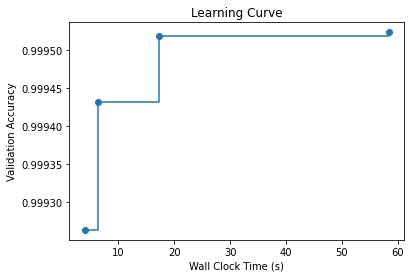

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()